In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../Data/DataBaseCrawler/GameLogCrawler/')
import ScrapeGameLogs as scGL

In [2]:
def MeanAndCleanGL(PlayerLog):
    #Clean the Rows
    CleanData=[]
    for row in PlayerLog.values:
        CleanRow =[int(row[3])]+[cleanGL(x) for x in row[5:]]
        CleanData.append(CleanRow)
        
    #Sum the Columns
    SummedRow = np.sum(CleanData, axis=0)
    
    #Get into Proper format
    G = SummedRow[1]
    PA = SummedRow[3]    
    
    #Format the row
    AvgRow = [x/PA for x in SummedRow[4:20]] + [x/G for x in SummedRow[20:21]]
    return AvgRow

In [3]:
def MeanRecentHistory(Date,GameLog,daysBack):
    #Make sure days back is less than 30.
    #If the date is before April 14th we just use total.
    Year = int(Date.split('-')[0])
    Month = int(Date.split('-')[1])
    Day = int(Date.split('-')[2]) - 1
    if Day == 0:
        Month = Month-1
        Day - 31
    
    if Month < 5 and Day < 14:
        #Use Last seasons stats - Check we have more than 5 data points, or just use total
        PlayerLog = GameLog[[str(Year-1) in x for x in GameLog['Date'].values]]
        #print(Year)
    elif Day - daysBack < 1:
        #Condition where we cross months.   
        #Get dates for first month
        DatesFirstMonth = [str(Year)+'-'+formatNumberString(Month)+'-'+formatNumberString(x) for x in range(1,Day+1)]
        #Get Dates for second month
        NewMonth = Month - 1     
        NewDay = (31 - (daysBack- Day))       
        DatesSecondMonth = [str(Year)+'-'+formatNumberString(NewMonth)+'-'+formatNumberString(x) for x in range(NewDay,31)]
        Dates = DatesFirstMonth + DatesSecondMonth
        PlayerLog = GameLog[GameLog['Date'].isin(Dates)]
    else:
        #Condition where we don't cross months
        NewMonth = Month
        NewDay = Day - daysBack
        Dates = [str(Year)+'-'+formatNumberString(NewMonth)+'-'+formatNumberString(x) for x in range(NewDay,Day+1)]
        PlayerLog = GameLog[GameLog['Date'].isin(Dates)]
        
    n, d = PlayerLog.shape
    if n < 5:
        return -1
    return MeanAndCleanGL(PlayerLog)

In [4]:
def Abv2Name(x):
	return {
		'ARI': 'Diamondbacks',
		'ATL': 'Braves',
		'BAL': 'Orioles',
		'CHC': 'Cubs',
		'CLE': 'Indians',
		'COL': 'Rockies',
		'DET': 'Tigers',
		'MIA': 'Marlins',
		'HOU': 'Astros',
		'LAA': 'Angels',
        'ANA': 'Angels',
        'CAL': 'Angels',
		'LAD': 'Dodgers',
		'MIL': 'Brewers',
		'MIN': 'Twins',
		'NYM': 'Mets',
		'NYY': 'Yankees',
		'OAK': 'Athletics',
		'PHI': 'Phillies',
		'PIT': 'Pirates',
		'SD': 'Padres',
		'SF': 'Giants',
		'SEA': 'Mariners',
		'STL': 'Cardinals',
		'TEX': 'Rangers',
		'TB': 'Rays',
		'TOR': 'Blue Jays',
		'WAS': 'Nationals',
		'BOS': 'Red Sox',
		'CIN': 'Reds',
		'CWS': 'White Sox',
		'KC': 'Royals',
		'CHW': 'White Sox',
		'KCR' : 'Royals',
		'SDP' : 'Padres',
		'SFG' : 'Giants',
		'TBR' : 'Rays',
        'WSN' : 'Nationals',
        'ATL' : 'Braves'
	}[x]

In [5]:
def cleanGL(x):
    try:
        out = float(x)
    except:
        try:
            out = float(x.strip('%'))
        except:
            out = 0
    return out

In [6]:
def formatNumberString(x):
    if x < 10:
        return '0'+str(x)
    else:
        return str(x)

In [7]:
def cleanPitcherStats(PitchingStats):
    PSD = PitchingStats.drop(columns=['HLD','BS','xFIP-','xFIP','SIERA'])
    G = PSD.values[0,5]
    IP = PSD.values[0,10]
                #Win /Loss                       #ERA             #GS CS ShutOut Save IP
    OutRow = [x/G for x in PSD.values[0,2:4]]+[PSD.values[0,4]]+[x/G for x in PSD.values[0,6:11]]+[x/IP for x in PSD.values[0,11:22]]+[x for x in PSD.values[0,22:]]    
    return OutRow

In [8]:
def cleanBatterStats(BattingStats):
    BSD=BattingStats.drop(columns=['UBR','wGDP'])
    G = BSD.values[0,2]
    PA = BSD.values[0,4]
    outStats = [cleanGL(x)/PA for x in BSD.values[0,5:21]]+[cleanGL(x) for x in BSD.values[0,21:]]
    return outStats

In [9]:
RetroSheetDict = {'LAA':'ANA', 'SEA': 'SEA', 'CHW':'CHA', 'CHC':'CHN','ARI':'ARI', 'BAL':'BAL', 'BOS':'BOS',
                  'CIN':'CIN', 'CLE':'CLE', 'COL':'COL', 'DET':'DET', 'HOU':'HOU', 'KCR':'KCA', 'LAD':'LAN', 'MIA':'MIA',
       'MIN':'MIN','MIL':'MIL', 'NYM':'NYN', 'NYY':'NYA', 'OAK':'OAK', 'PHI':'PHI', 'PIT':'PIT', 'SDP':'SDN', 'SFG':'SFN',
       'STL':'SLN','TOR':'TOR', 'TBR':'TBA', 'TEX':'TEX', 'WSN':'WAS', 'MON':'MON', 'ATL':'ATL', 'FLA':'FLO', 'TBD':'TBA','ANA':'ANA','CAL':'CAL'}

In [10]:
#Load The Rosters
ActiveBatter = pd.read_csv('../Data/DataBaseCrawler/MLBBatterRoster2018.csv', index_col=0)
InActiveBatter = pd.read_csv('../Data/DataBaseCrawler/GameLogs/InactiveBatterList.csv', index_col=0)

#Load all the data - Clusters
BatterClusters = pd.read_csv('./BatterClusters/PredBattingClusters.csv', index_col=0)
PitcherClusters = pd.read_csv('./PitcherClusters/TotalPitchingClusters.csv', index_col=0)

#Player Info -- Hardcoded for now.
ID = BatterClusters[BatterClusters['Name']=='Mike Trout']['ID'].values[0]
ClusterNum = BatterClusters[BatterClusters['Name']=='Mike Trout']['Labels'].values[0]
if ID in ActiveBatter['ID'].values:
    Link = ActiveBatter[ActiveBatter['ID']==ID]['Link'].values[0]
else:
    Link = InActiveBatter[InActiveBatter['ID']==ID]['Link'].values[0]

#Factors.
UmpireFactors = pd.read_csv('../Data/Factors/UmpireFactors.csv', index_col=0)
CatcherFactors = pd.read_csv('../Data/Factors/CatcherFactors.csv', index_col=0)
ParkFactors = pd.read_csv('../Data/Factors/ParkFactors.csv', index_col=0)

#HistoricalPitching Stats
TeamPitchingStats = pd.read_csv('../Data/TeamStats/TeamPitchingStats.csv', index_col=0)
TeamBattingStats = pd.read_csv('../Data/TeamStats/TeamBattingStats.csv', index_col=0)

In [60]:
#Pick CLuster number
Batters = BatterClusters[BatterClusters['Labels']==ClusterNum]
PlayerData=[]
FPs=[]
for ID in Batters['ID'].values:

    #Get GameLog 
    #PlayerLogMain = pd.read_csv('../Data/DataBaseCrawler/GameLogs/Batters/'+str(ID)+'GL.csv',index_col=0)
    
    if ID in ActiveBatter['ID'].values:
        PlayerLogMain = pd.read_csv('../Data/DataBaseCrawler/GameLogs/Batters/'+str(ID)+'GL.csv',index_col=0)
    else:
        PlayerLogMain = pd.read_csv('../Data/DataBaseCrawler/GameLogs/InactiveBatters/'+str(ID)+'GL.csv',index_col=0)

    #Get the PlayerLog
    PlayerLog = PlayerLogMain[PlayerLogMain['Date']!='Total']
    #Only use dates before 2018
    PlayerLog = PlayerLog[['2018' not in x for x in PlayerLog['Date'].values]]
    #FP = PlayerLog['DKfp'].values

 
    for Row1 in PlayerLog.values:
        #Build 1 feature vector
        #Row1 = PlayerLog.values[0]

        #Load schedule
        Date = Row1[0]
        Year = Date.split('-')[0]
        Schedule = pd.read_csv('../Data/Schedules/RSSchedules/RSSchedule'+str(Year)+'.csv',index_col=0)

        #Load Batting Order
        BO = Row1[3]
        BOHC = np.zeros(9)
        BOHC[int(BO)-1] = 1

        #Figure out if we are home or not
        if '@' in Row1[2]:
            Home = False
            AwayTeam = Row1[1]
            PlayerTeam = AwayTeam
            HomeTeam = Row1[2].strip('@')
            OppTeam = HomeTeam
            HFA = 1
        else:
            Home = True
            AwayTeam = Row1[2].strip('@')
            OppTeam = AwayTeam
            HomeTeam = Row1[1]
            PlayerTeam = HomeTeam
            HFA = 0

        #Find the game in the schedule
        ScheduleG = Schedule[Schedule['Date']==Date]
        ScheduleG = ScheduleG[ScheduleG['Home Team']==RetroSheetDict[HomeTeam]]
        ScheduleG = ScheduleG[Schedule['Visiting Team']==RetroSheetDict[AwayTeam]]

        #Get Field info
        StadiumID = ScheduleG['Stadium ID'].values[0]
        UmpireID = ScheduleG['Umpire ID'].values[0]
        ParkRow = ParkFactors[ParkFactors['Park ID']==StadiumID].values[0,12:].tolist()

        #Find Catchers
        Catchers=np.where(ScheduleG.values==2)[1]

        #Get Player info
        if Home:
            PitcherName =  ScheduleG['Away Pitcher Name']
            CatcherID =  ScheduleG.values[0,Catchers[1]-2]
        else:
            PitcherName =  ScheduleG['Home Pitcher Name']
            CatcherID =  ScheduleG.values[0,Catchers[0]-2]
        try:
            #Get Pitcher cluster
            Label = PitcherClusters[PitcherClusters['Name']==PitcherName.values[0]]['Labels'].values[0]

            #Get the Cluster Split - Features
            ClusterSplit = pd.read_csv('./ClusterSplits/BatterSplit'+str(ClusterNum)+'.csv', index_col=0)
            ClusterSplit.drop(columns=['BO', 'G_x','AB','PA', 'DKfp_x'], inplace=True)
            SplitColumn = ClusterSplit.as_matrix()[Label,:]

            #Get umpire factors
            UmpireFactorsRow = UmpireFactors[UmpireFactors['Umpire Id']==UmpireID][['K Factor', 'Walk Factor', 'Hit Factor']].values[0]

            #Get Catcher Factors
            CatcherFactorsRow = CatcherFactors[CatcherFactors['Catcher Id']==CatcherID][['Catcher Success','Steals Attempts per Game']].values[0]

            #Get opposite team pitching  stats
            YearTeamPitching=TeamPitchingStats[TeamPitchingStats['Year']==int(Year)]
            OppTeamPitchingStats=YearTeamPitching[YearTeamPitching['Team']==Abv2Name(OppTeam)]
            PitcherRow = cleanPitcherStats(OppTeamPitchingStats)

            #Get our Teams batting stats
            YearTeamBattingStats=TeamBattingStats[TeamBattingStats['Year']==int(Year)]
            ThisTeamBattingStats=YearTeamBattingStats[YearTeamBattingStats['Team']==Abv2Name(PlayerTeam)]
            TeamBattingRow = cleanBatterStats(ThisTeamBattingStats)

            #Get recent history.
            RecentHist = MeanRecentHistory(Date,PlayerLog, 10)

            if RecentHist == -1:
                PlayerLogTotal=PlayerLogMain[PlayerLogMain['Date']=='Total']
                G = PlayerLogMain.values[0,5]
                PA = PlayerLogMain.values[0,7]
                RecentHist = [x/PA for x in PlayerLogTotal.values[0,8:24]]+[PlayerLogTotal.values[0,24]]

            #Make the Row
            FinalRow=SplitColumn.tolist()+RecentHist+TeamBattingRow+PitcherRow+CatcherFactorsRow.tolist()+UmpireFactorsRow.tolist()+ParkRow+BOHC.tolist()+[HFA]
            if not np.isnan(FinalRow).any():
                PlayerData.append(FinalRow)
                FPs.append(Row1[25])
        except:
            print('Row failed!')

/home/josh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row failed!
Row 

In [61]:
#Scale The Data
scaler = StandardScaler()
ScaledData = scaler.fit_transform(PlayerData)

In [77]:
#Feature Selection
Y = FPs
ErrorTrain=[]
ErrorTest=[]

clf = linear_model.Lasso(alpha=0.01).fit(ScaledData,Y)
model = SelectFromModel(clf,prefit=True)
ScaledDataSelected = model.transform(ScaledData)
#ScaledDataSelected = ScaledData

n, d = ScaledData.shape
print(d)


n2,d2 = ScaledDataSelected.shape
print(d2)

#Train Test Split
#for alph in np.logspace(-2,3,num=10):
ErrorTrainTemp=[]
ErrorTestTemp=[]

X_train, X_test, y_train, y_test = train_test_split(ScaledDataSelected, Y, test_size=0.3, random_state=42)

ntrain=len(y_train)
ntest=len(y_test)

#Network
Predictor = MLPRegressor(hidden_layer_sizes=(9, ),alpha=5 activation='logistic', max_iter=10000)
Predictor.fit(X_train, y_train)
ErrorTrainTemp.append(sum((y_train - Predictor.predict(X_train))**2)/ntrain)
ErrorTestTemp.append(sum((y_test - Predictor.predict(X_test))**2)/ntest)

ErrorTrain.append(np.mean(ErrorTrainTemp))
ErrorTest.append(np.mean(ErrorTestTemp))

print(ErrorTrain)
print(ErrorTest)

SyntaxError: invalid syntax (<ipython-input-77-777e6377da67>, line 29)

In [78]:
ErrorTrain

[61.21501163371926]

In [79]:
ErrorTest

[69.10342776387316]

(array([2.000e+00, 5.000e+00, 3.600e+01, 9.300e+01, 2.380e+02, 4.910e+02,
        7.430e+02, 9.020e+02, 9.110e+02, 9.710e+02, 1.013e+03, 1.049e+03,
        1.018e+03, 9.950e+02, 9.920e+02, 9.600e+02, 9.490e+02, 8.300e+02,
        7.440e+02, 6.380e+02, 5.560e+02, 5.200e+02, 4.520e+02, 4.600e+02,
        4.330e+02, 4.370e+02, 4.020e+02, 3.640e+02, 3.710e+02, 3.920e+02,
        3.330e+02, 3.490e+02, 2.660e+02, 2.580e+02, 2.490e+02, 2.220e+02,
        1.800e+02, 1.810e+02, 1.660e+02, 1.230e+02, 1.050e+02, 8.200e+01,
        9.200e+01, 6.900e+01, 8.000e+01, 6.400e+01, 6.200e+01, 5.400e+01,
        5.100e+01, 4.000e+01, 2.600e+01, 3.100e+01, 2.800e+01, 2.600e+01,
        2.400e+01, 1.300e+01, 1.400e+01, 1.800e+01, 8.000e+00, 1.000e+01,
        7.000e+00, 7.000e+00, 5.000e+00, 6.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+0

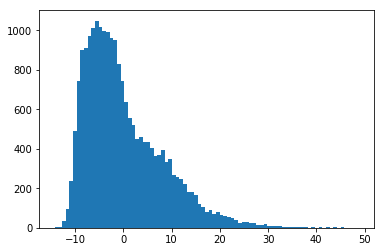

In [65]:
Predictor = MLPRegressor(hidden_layer_sizes=(9, ), alpha=25, max_iter=10000)
Predictor.fit(ScaledDataSelected, Y)
plt.hist(Y - Predictor.predict(ScaledDataSelected), bins='auto')

In [66]:
sum((Y - Predictor.predict(ScaledDataSelected))**2)/n

65.31017160417716

In [67]:
Predictor.predict(ScaledDataSelected)

array([ 9.42929635,  9.52120807, 11.58399136, ...,  2.28948849,
        4.16688186,  5.56540724])

In [68]:
np.min(Predictor.predict(ScaledDataSelected))

0.45929481163276864

In [69]:
np.max(Predictor.predict(ScaledDataSelected))

16.058979000058116

In [21]:
Batters

,Name,ID,Labels,Active
107,Mike Trout,10155,11,Y
118,Albert Pujols,1177,11,Y
191,Joey Votto,4314,11,Y
208,Paul Goldschmidt,9218,11,Y
359,Matt Holliday,1873,11,Y
394,Miguel Cabrera,1744,11,Y
518,Lance Berkman,548,11,N
808,Vladimir Guerrero,778,11,N
844,Todd Helton,432,11,N
912,Chipper Jones,97,11,N
